In [1]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [2]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.path.join(os.getenv("OUTPUTS_PATH"), "robustness_checks", "rb3")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [3]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [4]:
# breakpoint = pd.to_datetime("2007-05-01")

# df["label"] = 1.0
# df.loc[df["date"] <= breakpoint, "label"] = 0

In [5]:
# Change that concerns the robustness check: randomly shuffling the column "label"
df['label'] = df['label'].sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [6]:
df

date                                               text  label
0   2004-01-03  Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...    0.0
1   2004-01-03  Ben S Bernanke: Conducting monetary policy at ...    1.0
2   2004-01-03  Alan Greenspan: Risk and uncertainty in moneta...    1.0
3   2004-01-04  Ben S Bernanke: Monetary policy and the econom...    0.0
4   2004-01-04  Roger W Ferguson, Jr: Lessons from past produc...    0.0
..         ...                                                ...    ...
595 2010-03-25  Ben S Bernanke: Federal Reserve's exit strateg...    0.0
596 2010-03-26  Daniel K Tarullo: Lessons from the crisis stre...    0.0
597 2010-03-26  Kevin Warsh: An ode to independence\nSpeech by...    0.0
598 2010-03-26  Brian P Sack: Dollar asset markets - prospects...    1.0
599 2010-03-31  Elizabeth A Duke: Restoring credit to communit...    0.0

[600 rows x 3 columns]

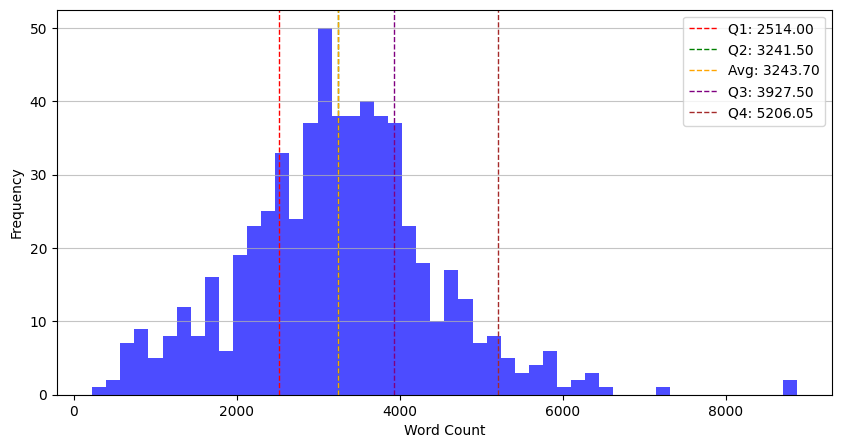

In [7]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Pre-processing data

##### 1. Data cleaning

In [8]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle
Loaded 600 texts


##### 2. Embedding texts

In [9]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle
Loaded 600 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [10]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_finbert.pickle
Loaded 600 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [11]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_distilbert.pickle
Loaded 600 sentiments


# TOPOL Modeling

### Prepare data

In [12]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

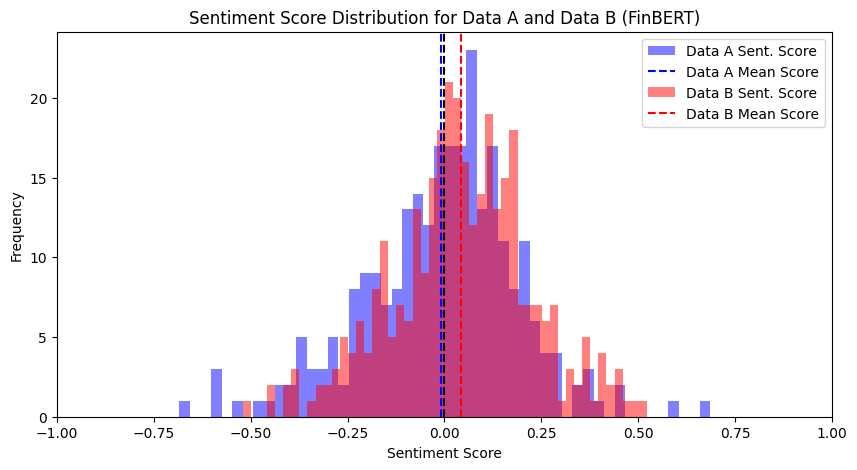

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

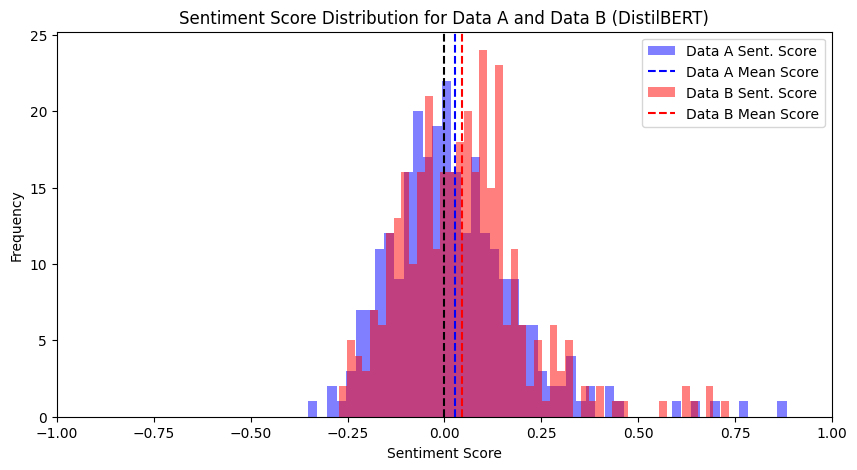

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [15]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=False,
)

### TOPOL modeling analysis

In [16]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

UMAP applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [17]:
topol_model.dataset_A.cluster_info

Cluster  Count                                          Top_Words  \
0        0     45  {'risk': 1409, 'financial': 1298, 'date': 964,...   
1        1     34  {'date': 1891, 'num': 881, 'inflation': 459, '...   
2        2     43  {'date': 2147, 'inflation': 1655, 'policy': 15...   
3        3     36  {'date': 1482, 'num': 897, 'credit': 732, 'mor...   
4        4     37  {'date': 1488, 'num': 907, 'economic': 458, 'f...   
5        5     34  {'date': 1020, 'reserve': 936, 'federal': 916,...   
6        6     28  {'financial': 1048, 'market': 812, 'risk': 798...   
7        7     10  {'date': 234, 'num': 116, 'education': 96, 'ec...   

                                            Centroid  \
0  [0.014763028676518136, 0.021201083110645412, 0...   
1  [0.011922713814248495, 0.022769235903123283, 0...   
2  [-0.00610398837848469, 0.003098065550972912, 0...   
3  [0.017840023456503533, 0.02470156375784427, 0....   
4  [0.013823944540392305, 0.014923462556514612, 0...   
5  [-0.0054125891127863295, 0.004261316035862204,...   
6  [0.0020417243524986717, 0.022028452454833314, ...   
7  [0.032190940459258854, -0.012144843395799399, ...   

                                 2D_Centroid  \
0    [9.190474806891547, -1.008944853146871]   
1   [12.529352384455064, -2.548638056306278]   
2     [12.559404328812, -0.5795608850325956]   
3    [10.62410897678799, -2.570051279332903]   
4  [13.402573946359995, -2.0064782999657296]   
5  [10.953007978551527, -0.9379057459094945]   
6    [9.749720028468541, -1.731526723929814]   
7   [12.083716487884521, -1.492843461036682]   

                             Top_Representative_Docs  \
0  [Susan Schmidt Bies: A US supervisor's perspec...   
1  [Frederic S Mishkin: Outlook and risks for the...   
2  [Donald L Kohn: Monetary policy research and t...   
3  [Randall S Kroszner: Loan modifications and fo...   
4  [Alan Greenspan: Globalization Remarks by Mr A...   
5  [Ben S Bernanke: Federal Reserve policies in t...   
6  [Donald L Kohn: Financial stability and policy...   
7  [Ben S Bernanke: The importance of financial e...   

                                     Top_Words_TFIDF  
0  {'risk': 0.3372082292678503, 'financial': 0.29...  
1  {'date': 0.5734882866782623, 'num': 0.28674414...  
2  {'inflation': 0.4242071544328394, 'date': 0.41...  
3  {'date': 0.5365149540804667, 'num': 0.29725828...  
4  {'date': 0.4416205173041885, 'num': 0.28254215...  
5  {'federal': 0.3323483304932159, 'financial': 0...  
6  {'financial': 0.47844863702700524, 'risk': 0.3...  
7  {'date': 0.5253674808590125, 'num': 0.26043858...

In [18]:
topol_model.dataset_B.cluster_info

Cluster  Count                                          Top_Words  \
0        0     64  {'risk': 2168, 'financial': 1751, 'capital': 1...   
1        1     58  {'date': 3832, 'num': 1939, 'prices': 1067, 'e...   
2        2     47  {'date': 2480, 'inflation': 2100, 'num': 1461,...   
3        3     45  {'date': 1664, 'num': 1100, 'credit': 835, 'mo...   
4        4     39  {'date': 1895, 'num': 1346, 'trade': 573, 'cur...   
5        5     38  {'date': 1245, 'federal': 1145, 'reserve': 108...   
6        6     37  {'financial': 1438, 'risk': 911, 'date': 797, ...   
7        7      5  {'date': 45, 'financial': 44, 'education': 30,...   

                                            Centroid  \
0  [0.012450412261955535, 0.019397688358367304, 0...   
1  [0.008511680073971892, 0.017365883807009406, 0...   
2  [-0.005310086662227169, -0.0016047613685356175...   
3  [0.02021775212811513, 0.021518933087888097, 0....   
4  [0.011751100480652008, 0.01689142648441096, 0....   
5  [-0.005758259649538607, 0.006134165717460411, ...   
6  [0.004059637915594755, 0.019526583551605407, 0...   
7  [0.015674218023195862, -0.019619199633598327, ...   

                                 2D_Centroid  \
0   [8.806909434497356, -0.8105156151868869]   
1  [12.665303690680142, -2.8762798080670424]   
2  [12.79257821022196, -0.39012144299402357]   
3    [10.229444143507216, -2.35589889658408]   
4  [13.778755823771158, -1.9876057795989208]   
5  [10.671005449796978, -1.0645895059661645]   
6    [9.812451594584697, -1.253610847920582]   
7  [11.827620506286621, -1.5734782174229622]   

                             Top_Representative_Docs  \
0  [Daniel K Tarullo: Modernizing bank supervisio...   
1  [Mark W Olson: Update on the US economy Remark...   
2  [Alan Greenspan: Jackson Hole Conference - ref...   
3  [Ben S Bernanke: Community development financi...   
4  [Timothy F Geithner: Developments in the globa...   
5  [Ben S Bernanke: Federal Reserve policies to e...   
6  [Timothy F Geithner: Liquidity risk and the gl...   
7  [Timothy F Geithner: The Fed Challenge Remarks...   

                                     Top_Words_TFIDF  
0  {'financial': 0.3619183758392408, 'risk': 0.35...  
1  {'date': 0.6297544951452254, 'num': 0.30126854...  
2  {'date': 0.46580560294758966, 'policy': 0.3593...  
3  {'date': 0.3943821436264509, 'num': 0.25386594...  
4  {'date': 0.38228498849591946, 'num': 0.3379858...  
5  {'federal': 0.3423486690392598, 'financial': 0...  
6  {'financial': 0.5278282329734879, 'risk': 0.35...  
7  {'date': 0.3386683868489137, 'financial': 0.33...

Drift computed successfully, ready to vizualize.


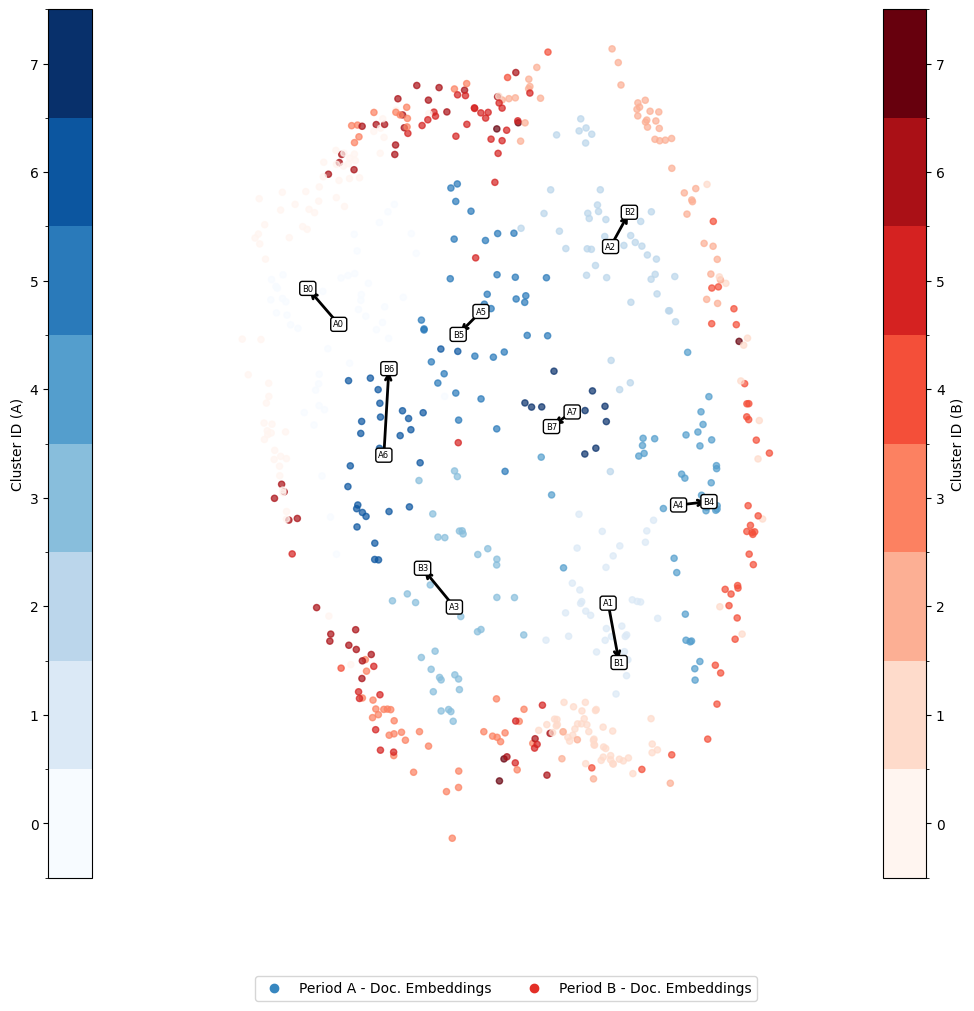

In [19]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [20]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
# drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [21]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

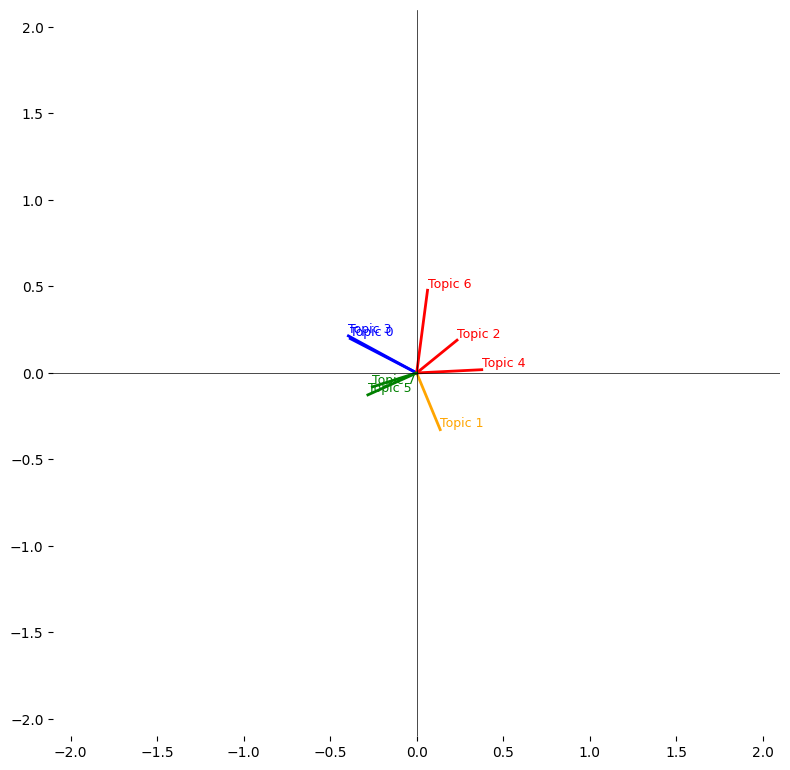

In [22]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [23]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [24]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [25]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [26]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [27]:
zipped_representative_docs = list(zip(
    topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
    topol_model.dataset_B.cluster_info['Top_Representative_Docs']
))
top_n_docs = 3  # Number of top documents to compare per cluster

for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

    # Get the representative documents for each cluster
    if top_n_docs is not None:
        text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
        text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
    else:
        text1 = from_list_to_string(top_docs_A)
        text2 = from_list_to_string(top_docs_B)

    # Generate the prompt for the LLM
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, max_tokens=1000000)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")

  0%|          | 0/8 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Financial Stability vs. Instability",
    "polar_extremes_subtitle": "Financial Stability – Financial Instability",
    "presence": "both",
    "coverage_text1": 30,
    "coverage_text2": 40,
    "difference_confidence": 25,
    "cosine_similarity": 0.85,
    "text1_evidence_sentences": [
      "As a central banker, I realize that a strong, stable financial system is necessary for the health of the broader economy.",
      "Despite a number of notable shocks, financial markets have generally remained stable in DATE.",
      "Businesses have been reporting strong profits and solid balance sheets."
    ],
    "text2_evidence_sentences": [
      "For DATE, the U.S. financial system has been under extraordinary stress.",
      "Initially, this financial stress precipitated a sharp downturn in the U.S. and global economies.",
      "We have seen in this crisis that flawed or inappropriate financial instruments can lead to bad results for famil